# 1. Autoencoder

In [0]:
import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import models
from keras import backend as K
from keras import layers
from keras.utils import to_categorical
import tensorflow as tf
import numpy as np
import cv2
import pandas as pd
from keras.datasets import fashion_mnist

In [0]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [0]:
from keras.datasets import mnist
import numpy as np

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

In [0]:
from keras.callbacks import TensorBoard
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                )

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 78s 1ms/step - loss: 0.3677 - val_loss: 0.3300
Epoch 2/50
60000/60000 [==============================] - 73s 1ms/step - loss: 0.3233 - val_loss: 0.3146
Epoch 3/50
60000/60000 [==============================] - 77s 1ms/step - loss: 0.3132 - val_loss: 0.3077
Epoch 4/50
60000/60000 [==============================] - 73s 1ms/step - loss: 0.3076 - val_loss: 0.3037
Epoch 5/50
60000/60000 [==============================] - 66s 1ms/step - loss: 0.3043 - val_loss: 0.3028
Epoch 6/50
60000/60000 [==============================] - 65s 1ms/step - loss: 0.3021 - val_loss: 0.3018
Epoch 7/50
60000/60000 [==============================] - 65s 1ms/step - loss: 0.3004 - val_loss: 0.3025
Epoch 8/50
60000/60000 [==============================] - 64s 1ms/step - loss: 0.2992 - val_loss: 0.2982
Epoch 9/50
60000/60000 [==============================] - 64s 1ms/step - loss: 0.2975 - val_loss: 0.2967
Epoch

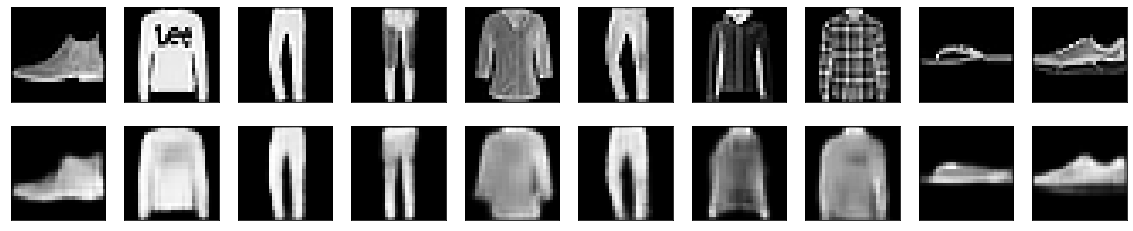

In [0]:
import matplotlib.pyplot as plt
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n+1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# 2. Image Classification

## 2.1 Deep CNN

In [0]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
#preparing the data for training
X_train = X_train.reshape(60000,28,28,1)
X_test = X_test.reshape(10000,28,28,1)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

#create sequential
model = models.Sequential()
#add layers
model.add(layers.Conv2D(64, kernel_size=3, activation='relu', input_shape=(28,28,1)))
model.add(layers.Conv2D(32, kernel_size=3, activation='relu'))
model.add(layers.Conv2D(16, kernel_size=3, activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#train the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3)

Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 124s 2ms/step - loss: 0.5004 - accuracy: 0.8374 - val_loss: 0.3820 - val_accuracy: 0.8635
Epoch 2/3
60000/60000 [==============================] - 118s 2ms/step - loss: 0.3200 - accuracy: 0.8855 - val_loss: 0.3996 - val_accuracy: 0.8615
Epoch 3/3
60000/60000 [==============================] - 123s 2ms/step - loss: 0.2803 - accuracy: 0.8979 - val_loss: 0.3297 - val_accuracy: 0.8839


In [0]:
model.evaluate(X_test, y_test)

10000/10000 [==============================] - 2s 245us/step


[0.32965097715854647, 0.883899986743927]

## 2.2 Transfer Learning

In [0]:
from keras.datasets import mnist
from keras.preprocessing.image import img_to_array, array_to_img
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
#resizing the images to fit min size of resnet
X_train = X_train.reshape(60000,28,28,1)
X_test = X_test.reshape(10000,28,28,1)
X_train = np.concatenate([X_train]*3, axis = -1)
X_test = np.concatenate([X_test]*3, axis = -1)
X_train = np.asarray([img_to_array(array_to_img(im, scale=False).resize((32, 32)))for im in X_train])
X_test = np.asarray([img_to_array(array_to_img(im, scale=False).resize((32, 32)))for im in X_test])
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print(X_train.shape)

(60000, 32, 32, 3)


In [0]:
#calling the resnet model
keras_layer = keras.applications.resnet.ResNet50(
    include_top=False, weights='imagenet', input_tensor=None, input_shape=(32,32,3), pooling=None, classes=10
)
res_Model = models.Sequential()
res_Model.add(keras_layer)
res_Model.add(layers.Flatten())
res_Model.add(layers.Dense(10, activation='softmax'))
res_Model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#train the model
res_Model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3)

Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 2818s 47ms/step - loss: 0.8108 - accuracy: 0.7724 - val_loss: 0.6414 - val_accuracy: 0.7667
Epoch 2/3
60000/60000 [==============================] - 2979s 50ms/step - loss: 0.6405 - accuracy: 0.8021 - val_loss: 0.8568 - val_accuracy: 0.6971
Epoch 3/3
60000/60000 [==============================] - 2766s 46ms/step - loss: 0.5114 - accuracy: 0.8358 - val_loss: 3.8811 - val_accuracy: 0.5610


In [0]:
res_Model.evaluate(X_test, y_test)

10000/10000 [==============================] - 31s 3ms/step


[3.8811142740249633, 0.5609999895095825]

# 3. Text Classification

## 3.1 RNN

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [0]:
df = pd.read_csv('twitter-data/tweets_with_labels.csv', sep='\t')
print(df.head())

   id                                              tweet   k1   k2   k3   k4  \
0   1                Jazz for a Rainy Afternoon:  {link}  0.0  0.0  0.0  0.0   
1   2                   RT: @mention: I love rainy days.  0.0  0.0  0.0  0.0   
2   3  Good Morning Chicago! Time to kick the Windy C...  0.0  0.0  0.0  0.0   
3   6  Preach lol! :) RT @mention: #alliwantis this t...  0.0  0.0  0.0  0.0   
4   9                     @mention good morning sunshine  0.0  0.0  0.0  0.0   

    k5   k6     k7   k8     k9  k10  k11  k12    k13  k14  k15  
0  0.0  0.0  0.000  0.0  0.000  1.0  0.0  0.0  0.000  0.0  0.0  
1  0.0  0.0  0.000  0.0  0.000  1.0  0.0  0.0  0.000  0.0  0.0  
2  0.0  0.0  1.000  0.0  0.000  0.0  0.0  0.0  0.000  0.0  0.0  
3  0.0  0.0  0.604  0.0  0.196  0.0  0.0  0.0  0.201  0.0  0.0  
4  0.0  0.0  0.000  0.0  0.000  0.0  0.0  0.0  1.000  0.0  0.0  


In [9]:
from google.colab import files
uploaded = files.upload()

Saving tweets_with_labels.csv to tweets_with_labels (1).csv


In [0]:
import io
df = pd.read_csv(io.BytesIO(uploaded['tweets_with_labels.csv']), sep='\t')

In [31]:
X=df['tweet']
y=df.iloc[:, 2:17]
print(X.head())
print(y.head())

0                  Jazz for a Rainy Afternoon:  {link}
1                     RT: @mention: I love rainy days.
2    Good Morning Chicago! Time to kick the Windy C...
3    Preach lol! :) RT @mention: #alliwantis this t...
4                       @mention good morning sunshine
Name: tweet, dtype: object
    k1   k2   k3   k4   k5   k6     k7  ...     k9  k10  k11  k12    k13  k14  k15
0  0.0  0.0  0.0  0.0  0.0  0.0  0.000  ...  0.000  1.0  0.0  0.0  0.000  0.0  0.0
1  0.0  0.0  0.0  0.0  0.0  0.0  0.000  ...  0.000  1.0  0.0  0.0  0.000  0.0  0.0
2  0.0  0.0  0.0  0.0  0.0  0.0  1.000  ...  0.000  0.0  0.0  0.0  0.000  0.0  0.0
3  0.0  0.0  0.0  0.0  0.0  0.0  0.604  ...  0.196  0.0  0.0  0.0  0.201  0.0  0.0
4  0.0  0.0  0.0  0.0  0.0  0.0  0.000  ...  0.000  0.0  0.0  0.0  1.000  0.0  0.0

[5 rows x 15 columns]


In [0]:
#divid x by space
length = X.size
val =[]
for i in range(length):
    val.append(X[i].split())
X.update(pd.Series(val))
print(X.head())

0            [Jazz, for, a, Rainy, Afternoon:, {link}]
1              [RT:, @mention:, I, love, rainy, days.]
2    [Good, Morning, Chicago!, Time, to, kick, the,...
3    [Preach, lol!, :), RT, @mention:, #alliwantis,...
4                  [@mention, good, morning, sunshine]
Name: tweet, dtype: object


In [32]:
#divid x into words/tokens using keras
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
print(X.head())

0                  Jazz for a Rainy Afternoon:  {link}
1                     RT: @mention: I love rainy days.
2    Good Morning Chicago! Time to kick the Windy C...
3    Preach lol! :) RT @mention: #alliwantis this t...
4                       @mention good morning sunshine
Name: tweet, dtype: object


In [0]:
def max_len(s):
    max_l = 0
    for c in s:
        if max_l<len(c):
            max_l=len(c)
    return max_l

In [0]:
maxlen = max_len(X)
char_size = len(tokenizer.word_index)+1
X_train, X_test, y_train,y_test = train_test_split(X,y,test_size = 0.20, random_state = 50)
train = tokenizer.texts_to_sequences(X_train)
test = tokenizer.texts_to_sequences(X_test)
X_tr = pad_sequences(train,maxlen=maxlen)
X_te = pad_sequences(test,maxlen=maxlen)

In [21]:
model_RNN = models.Sequential()
model_RNN.add(layers.Embedding(maxlen, 64, trainable=False))
model_RNN.add(layers.LSTM(64))
model_RNN.add(layers.Dense(64, activation ='relu'))
model_RNN.add(layers.Dropout(0.2))
model_RNN.add(layers.Dense(32, activation='relu'))
model_RNN.add(layers.Dropout(0.2))
model_RNN.add(layers.Dense(15, activation='softmax'))
print(model_RNN.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 64)          11520     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_6 (Dense)              (None, 15)                495       
Total params: 51,279
Trainable params: 39,759
Non-trainable params: 11,520
_________________________________________________________________
None


In [20]:
opt = keras.optimizers.adam(lr=3e-4)
model_RNN.compile(optimizer = opt,
             loss = 'categorical_crossentropy',
             metrics=['categorical_accuracy'])
rnn_history = model_RNN.fit(X_tr, y_train,epochs = 10, batch_size = 16,validation_data =[X_te,y_test])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 62356 samples, validate on 15590 samples
Epoch 1/10





62356/62356 [==============================] - 850s 14ms/step - loss: 2.4823 - categorical_accuracy: 0.3824 - val_loss: 2.2202 - val_categorical_accuracy: 0.4821
Epoch 2/10
62356/62356 [==============================] - 845s 14ms/step - loss: 2.0424 - categorical_accuracy: 0.5649 - val_loss: 1.9223 - val_categorical_accuracy: 0.6101
Epoch 3/10
62356/62356 [==============================] - 859s 14ms/step - loss: 1.8791 - categorical_accuracy: 0.6225 - val_loss: 1.8138 - val_categorical_accuracy: 0.6479
Epoch 4/10
62356/62356 [==============================] - 839s 13ms/step - loss: 1.7550 - categorical_accuracy: 0.6657 - val_loss: 1.6970 - val_categorical_accuracy: 0.6833
Epoch 5/10
62356/62356 [==============================] - 839s 13ms/step - loss: 1.6598 - categorical_accuracy: 0.6987 - val_loss: 1.6453 - val_categorica

## 3.2 CNN

In [35]:
model_CNN = models.Sequential()
model_CNN.add(layers.Embedding(maxlen,128))
model_CNN.add(layers.Conv1D(128,3,padding='valid',activation='relu'))
model_CNN.add(layers.GlobalMaxPooling1D())
model_CNN.add(layers.Dropout(0.2))
model_CNN.add(layers.Dense(64,activation='relu'))
model_CNN.add(layers.Dropout(0.2))
model_CNN.add(layers.Dense(32,activation='relu'))
model_CNN.add(Dense(15,activation='sigmoid'))
print(model_CNN.summary())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 128)         23040     
_________________________________________________________________
conv1d_9 (Conv1D)            (None, None, 128)         49280     
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 128)               0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 32)               

In [36]:
model_CNN.compile(optimizer = 'adam',
             loss = 'categorical_crossentropy',
             metrics=['categorical_accuracy'])
cnn_history = model_CNN.fit(X_tr, y_train,epochs = 15, batch_size = 128,validation_data =[X_te,y_test])

Train on 62356 samples, validate on 15590 samples
Epoch 1/15
62356/62356 [==============================] - 4s 69us/step - loss: 1.7415 - categorical_accuracy: 0.6415 - val_loss: 1.3247 - val_categorical_accuracy: 0.7851
Epoch 2/15
62356/62356 [==============================] - 4s 58us/step - loss: 1.3633 - categorical_accuracy: 0.7827 - val_loss: 1.2977 - val_categorical_accuracy: 0.7858
Epoch 3/15
62356/62356 [==============================] - 4s 58us/step - loss: 1.3380 - categorical_accuracy: 0.7857 - val_loss: 1.2897 - val_categorical_accuracy: 0.7859
Epoch 4/15
62356/62356 [==============================] - 4s 58us/step - loss: 1.3198 - categorical_accuracy: 0.7869 - val_loss: 1.2866 - val_categorical_accuracy: 0.7838
Epoch 5/15
62356/62356 [==============================] - 4s 60us/step - loss: 1.3099 - categorical_accuracy: 0.7881 - val_loss: 1.2827 - val_categorical_accuracy: 0.7824
Epoch 6/15
62356/62356 [==============================] - 4s 60us/step - loss: 1.2998 - categor

## 3.3 Plot

In [0]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

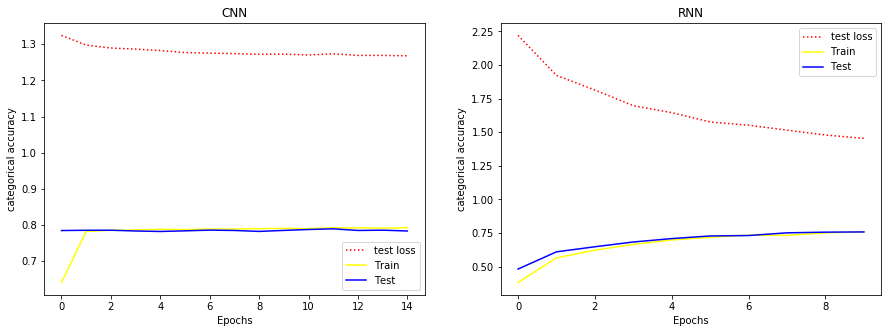

In [48]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['val_loss'], color = 'red', linestyle=':')
plt.plot(cnn_history.history['categorical_accuracy'], color = 'yellow')
plt.plot(cnn_history.history['val_categorical_accuracy'], color = 'blue')
plt.title('CNN')
plt.ylabel('categorical accuracy')
plt.xlabel('Epochs')
plt.legend(['test loss', 'Train', 'Test'])

plt.subplot(1, 2, 2)
plt.plot(rnn_history.history['val_loss'],color = 'red', linestyle=':')
plt.plot(rnn_history.history['categorical_accuracy'],color = 'yellow')
plt.plot(rnn_history.history['val_categorical_accuracy'],color = 'blue')
plt.title('RNN')
plt.ylabel('categorical accuracy')
plt.xlabel('Epochs')
plt.legend(['test loss', 'Train', 'Test'])
plt.show()